# CICDDoS2019

In [ ]:
import os
import pandas as pd
import seaborn as sns
from py.functions import (
    plot_confusion_matrix, 
    criar_stream, 
    carregar_e_unificar,
    visualizar_radares_separados_referencia,
    visualizar_assinaturas_barras
)
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, MinMaxScaler
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# relatorio_grupos = analisar_grupos_similares(df_analise, top_features, limiar=0.98)
# display(relatorio_grupos)

# identificar_assinaturas_por_ataque(df_analise, 5, 10000, n_iteracoes=10)

## Processamento 

### Downsample 

In [57]:
def processar_e_salvar_dia(
        dia, 
        dataset_path, 
        chunk_size, 
        cols_to_drop, 
        attack_order, 
        output_files, 
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME (O que você já fez)
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# Simula o REAL
# DOWNSAMPLE_FACTORS = {
#     'BENIGN': 1.0,           
#     'WebDDoS': 1.0,          
#     'TFTP': 0.0002,          
#     'DrDoS_DNS': 0.001,      
#     'DrDoS_LDAP': 0.001,
#     'DrDoS_MSSQL': 0.001,
#     'DrDoS_NTP': 0.001,
#     'DrDoS_NetBIOS': 0.001,
#     'DrDoS_SNMP': 0.001,
#     'DrDoS_SSDP': 0.001,
#     'DrDoS_UDP': 0.001,
#     'LDAP': 0.001,            
#     'MSSQL': 0.001,
#     'NetBIOS': 0.001,
#     'UDP': 0.001,
#     'Syn': 0.0015,            
#     'UDPLag': 0.005,           
#     'Portmap': 0.01,          
#     'Default': 0.001          
# }

# A Classe Ataques Majoritária
# DOWNSAMPLE_FACTORS = {
#     'WebDDoS': 1.0,          
#     'TFTP': 0.001,           
#     # Reflexão Massiva
#     'DrDoS_DNS': 0.01,       
#     'DrDoS_LDAP': 0.01,
#     'DrDoS_MSSQL': 0.01,
#     'DrDoS_NTP': 0.01,
#     'DrDoS_NetBIOS': 0.01,
#     'DrDoS_SNMP': 0.01,
#     'DrDoS_SSDP': 0.01,
#     'DrDoS_UDP': 0.01,
#     # FAMÍLIA EXPLORAÇÃO/REFLEXÃO 
#     'LDAP': 0.01,            
#     'MSSQL': 0.01,
#     'NetBIOS': 0.01,
#     'UDP': 0.01,
#     # FAMÍLIA TÁTICA 
#     'Syn': 0.05,             
#     'Portmap': 0.1,          
#     'UDPLag': 0.2,           
#     'Default': 0.01          
# }


# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


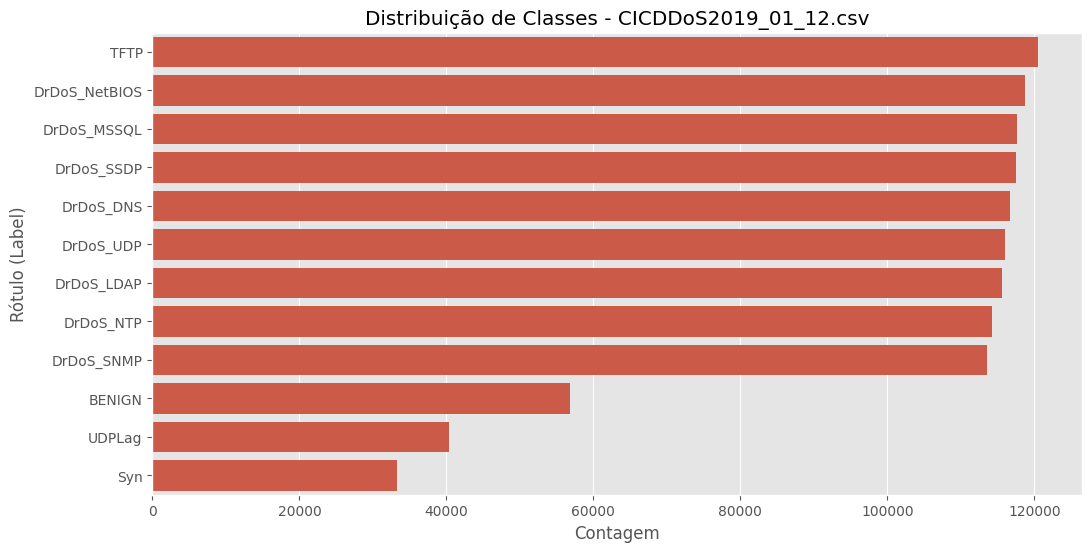

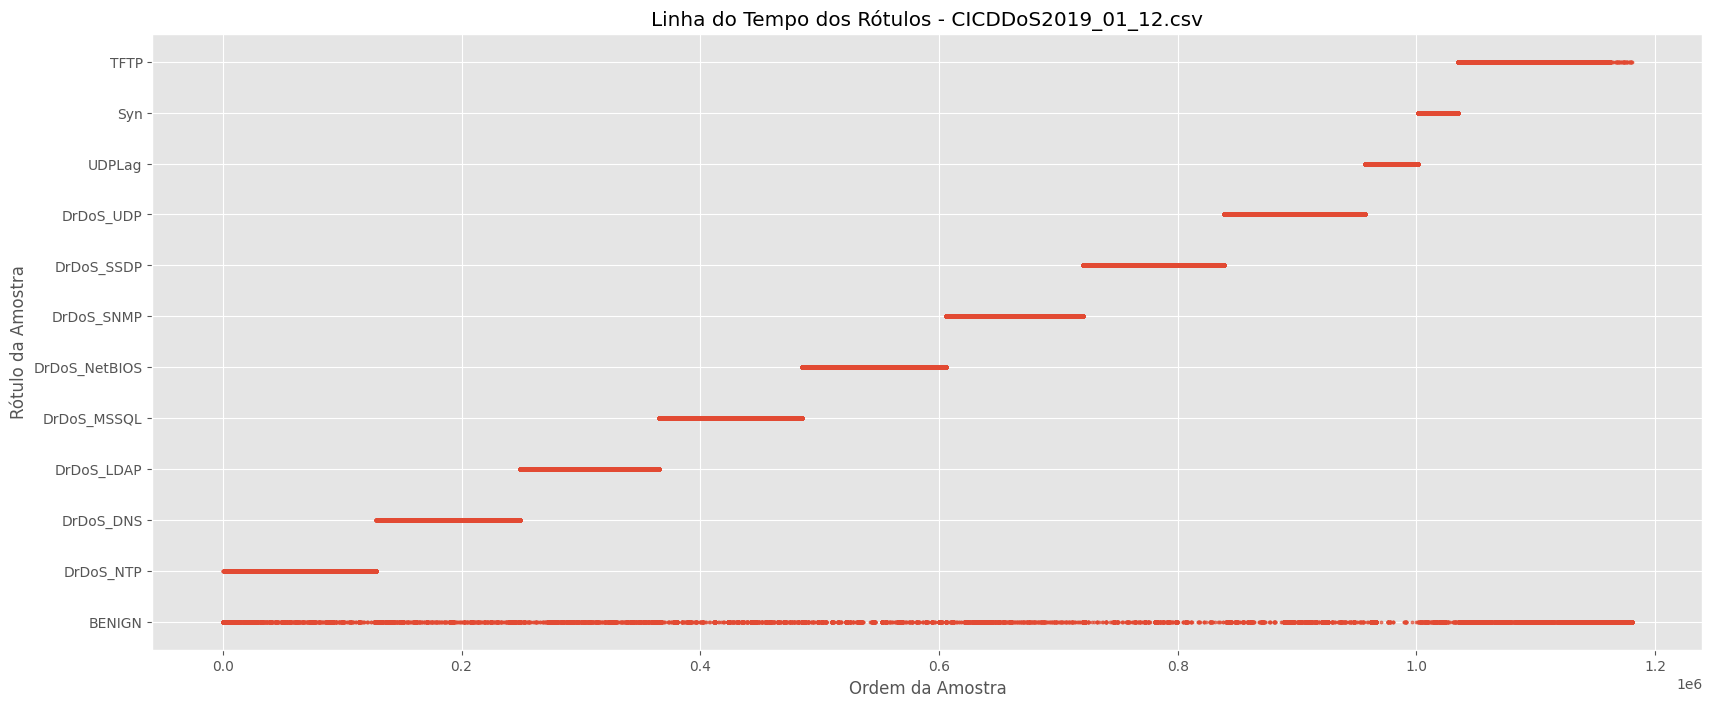

In [71]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

![Ataques](datasets/CICDDoS2019/img/ataques.png)

### DEVELOP CICDDoS2019

In [ ]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv',  
    'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'     
]

df = carregar_e_unificar(ARQUIVOS_ALVO, 100000)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 2000263 linhas.


Label
Syn              123215
Portmap          121524
MSSQL            121234
TFTP             120511
UDPLag           119680
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
NetBIOS          117459
UDP              117152
DrDoS_DNS        116641
DrDoS_UDP        115985
LDAP             115946
DrDoS_LDAP       115536
DrDoS_NTP        114251
BENIGN           113828
DrDoS_SNMP       113522
Name: count, dtype: int64

In [22]:
print("1. Preparação dos Dados")

TAMANHO_AMOSTRA = 200000

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df['Label'].unique())

df_amostra = df.groupby('Label').apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=['Label'])
y = df_amostra['Label']

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = MinMaxScaler() 
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN           11764
DrDoS_DNS        11764
DrDoS_LDAP       11764
DrDoS_MSSQL      11764
DrDoS_NTP        11764
DrDoS_NetBIOS    11764
DrDoS_SNMP       11764
DrDoS_SSDP       11764
DrDoS_UDP        11764
LDAP             11764
MSSQL            11764
NetBIOS          11764
Portmap          11764
Syn              11764
TFTP             11764
UDP              11764
UDPLag           11764
Name: count, dtype: int64

In [23]:
print("2. Seleção de Features e Extração de DNA Comportamental")

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)

# O X_trans agora já está entre 0 e 1 (correto)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] 
feature_names_final = X_numeric.columns[indices_top]

print(f"Features Selecionadas: {list(feature_names_final)}")

print(" > Calculando perfil típico de cada ataque...")

# Filtramos o dataset original (já normalizado Globalmente)
X_top_features = pd.DataFrame(X_trans, columns=X_numeric.columns).iloc[:, indices_top]
X_top_features['Label'] = y.values

# Calculamos a MEDIANA. 
df_final_sig = X_top_features.groupby('Label').median()

print(" > Matriz de Assinaturas (Comportamental) Gerada!")
display(df_final_sig)

2. Seleção de Features e Extração de DNA Comportamental
Features Selecionadas: ['Inbound', 'Subflow Fwd Packets', 'Fwd IAT Total', 'Flow IAT Std', 'Fwd IAT Max', 'Flow Packets/s', 'Flow IAT Mean', 'Init_Win_bytes_forward', 'ACK Flag Count', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Min Packet Length', 'Subflow Fwd Bytes', 'Fwd Packet Length Mean', 'Max Packet Length', 'Fwd Packet Length Max', 'Avg Fwd Segment Size', 'Fwd Packet Length Min', 'Packet Length Mean', 'Average Packet Size']
 > Calculando perfil típico de cada ataque...
 > Matriz de Assinaturas (Comportamental) Gerada!


,Inbound,Subflow Fwd Packets,Fwd IAT Total,Flow IAT Std,Fwd IAT Max,Flow Packets/s,Flow IAT Mean,Init_Win_bytes_forward,ACK Flag Count,Flow Bytes/s,Total Length of Fwd Packets,Min Packet Length,Subflow Fwd Bytes,Fwd Packet Length Mean,Max Packet Length,Fwd Packet Length Max,Avg Fwd Segment Size,Fwd Packet Length Min,Packet Length Mean,Average Packet Size
Label,,,,,,,,,,,,,,,,,,,,
BENIGN,0.0,0.000010,2.500005e-08,0.000266,2.501294e-08,4.795423e-05,1.412960e-04,0.003891,0.0,2.526179e-06,0.000483,0.000000,0.000483,0.014326,0.001313,0.008633,0.014326,0.002951,0.009500,0.011867
DrDoS_DNS,1.0,0.000010,8.333350e-09,0.000000,8.337647e-09,5.000000e-01,2.034500e-08,0.000000,0.0,9.945652e-01,0.022950,1.000000,0.022950,0.724053,0.042009,0.409914,0.724053,0.724053,0.413708,0.620178
DrDoS_LDAP,1.0,0.000010,8.333350e-09,0.000000,8.337647e-09,5.000000e-01,2.034500e-08,0.000000,0.0,1.000000e+00,0.022950,1.000000,0.022950,0.724053,0.042009,0.409914,0.724053,0.724053,0.413708,0.620178
DrDoS_MSSQL,1.0,0.000010,8.333350e-09,0.000000,8.337647e-09,5.000000e-01,2.034500e-08,0.000000,0.0,3.104620e-01,0.007608,0.331522,0.007608,0.240039,0.013927,0.135895,0.240039,0.240039,0.137153,0.205181
DrDoS_NTP,1.0,0.000391,8.312516e-06,0.000001,1.717555e-06,1.078628e-02,4.919187e-07,0.000000,0.0,6.280991e-03,0.132710,0.298913,0.132710,0.216429,0.012557,0.122529,0.216429,0.216429,0.123663,0.124731
DrDoS_NetBIOS,1.0,0.000010,8.333350e-09,0.000000,8.337647e-09,5.000000e-01,2.034500e-08,0.000000,0.0,1.555707e-01,0.003570,0.155571,0.003570,0.112641,0.006535,0.063771,0.112641,0.112641,0.064361,0.096482
DrDoS_SNMP,1.0,0.000010,1.666670e-08,0.000000,1.667529e-08,2.500000e-01,4.069000e-08,0.000000,0.0,5.000000e-01,0.022950,1.000000,0.022950,0.724053,0.042009,0.409914,0.724053,0.724053,0.413708,0.620178
DrDoS_SSDP,1.0,0.000010,4.083341e-07,0.000000,4.085447e-07,1.020407e-02,9.969051e-07,0.000000,0.0,5.310004e-03,0.010898,0.254755,0.010898,0.184456,0.011102,0.108326,0.184456,0.184456,0.105394,0.157994
DrDoS_UDP,1.0,0.000030,3.754174e-06,0.000004,3.389253e-06,3.157941e-03,1.932775e-06,0.000000,0.0,1.913649e-03,0.010898,0.243207,0.010898,0.181505,0.011102,0.108326,0.181505,0.176094,0.103596,0.139035


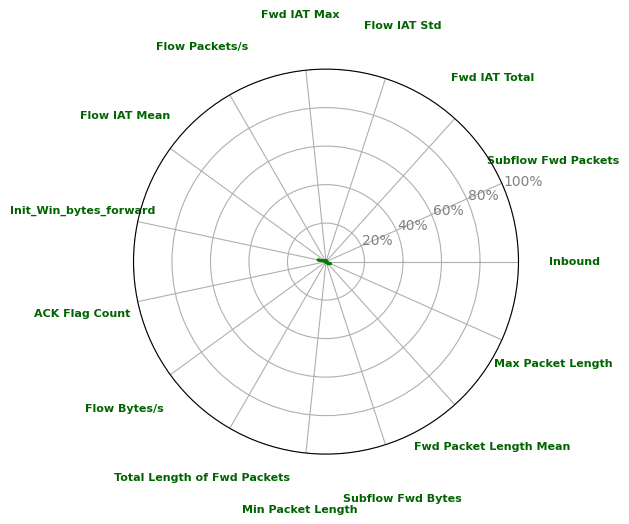

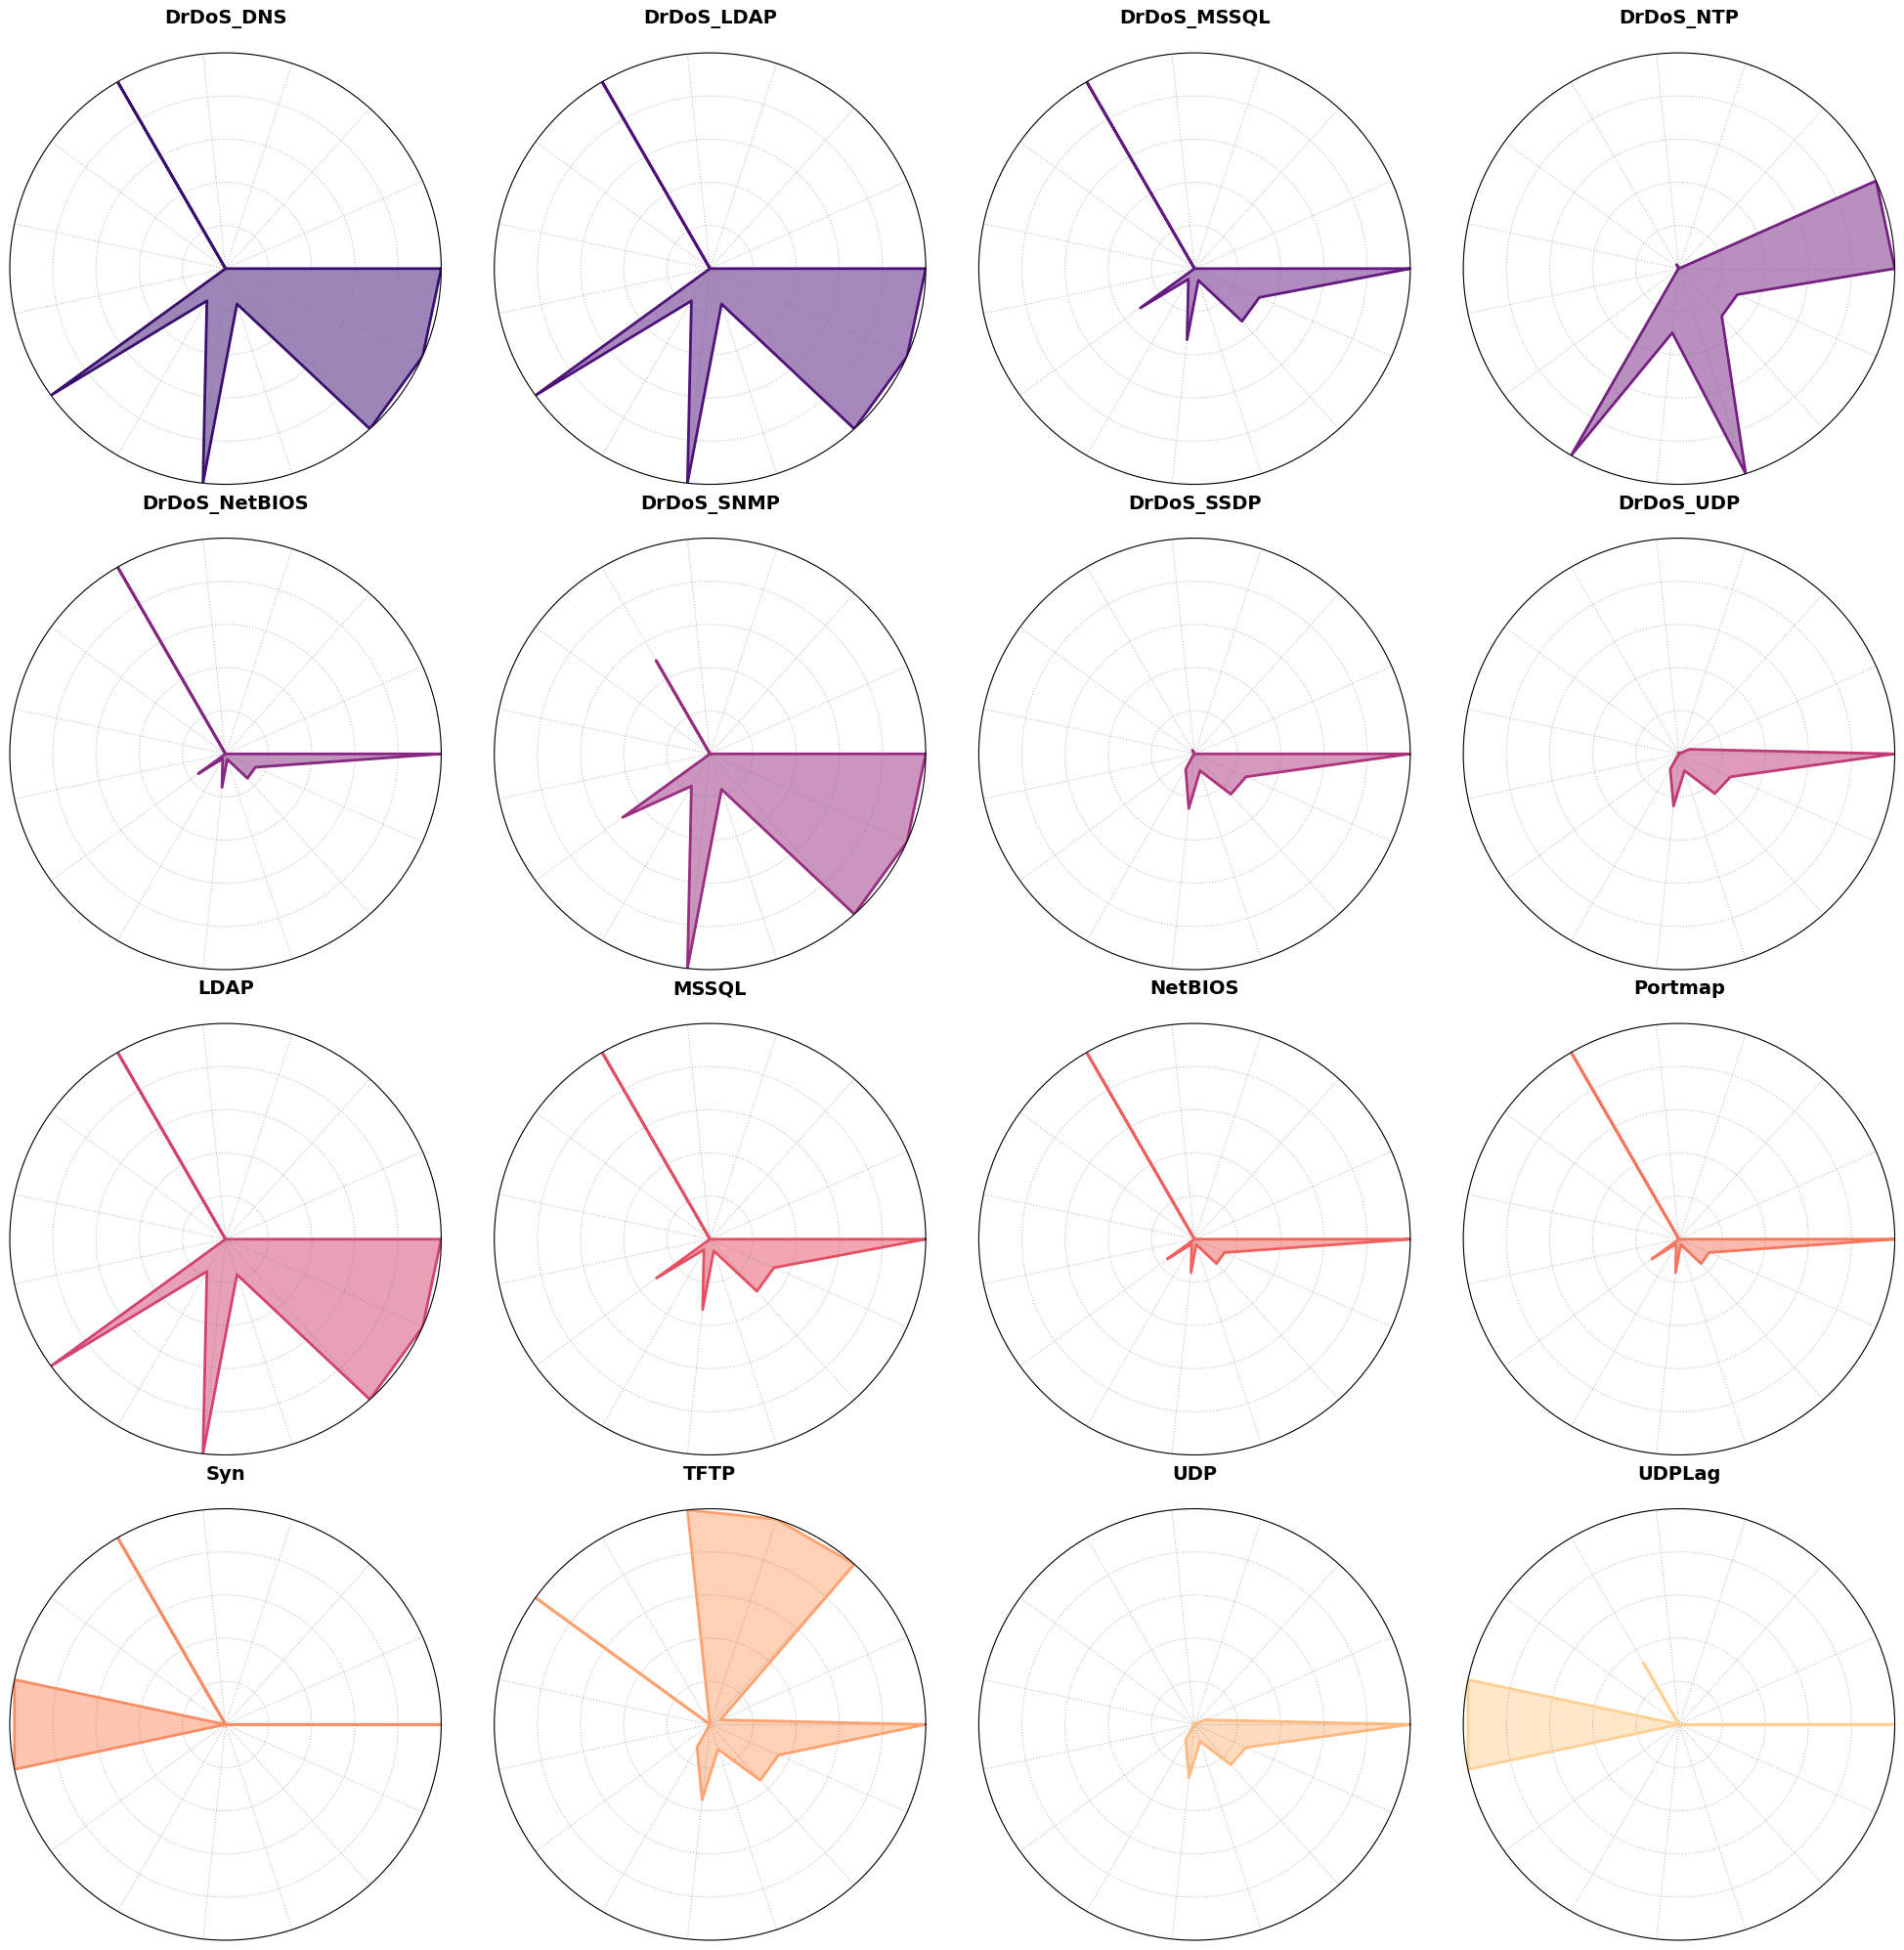

In [24]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares_separados_referencia(df_radar_ready, features_para_plotar)

Corte utilizado: 0.72
Métrica: MANHATTAN
Ligação: SINGLE


,Grupo ID,Qtd,Ataques,Manhattan,Assinatura
0,1,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
1,2,1,DrDoS_SNMP,Único,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,2,"Syn, UDPLag",0.3333,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,4,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.3787,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
4,5,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"Inbound, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Mean"
5,6,2,"DrDoS_MSSQL, MSSQL",0.0221,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
6,7,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


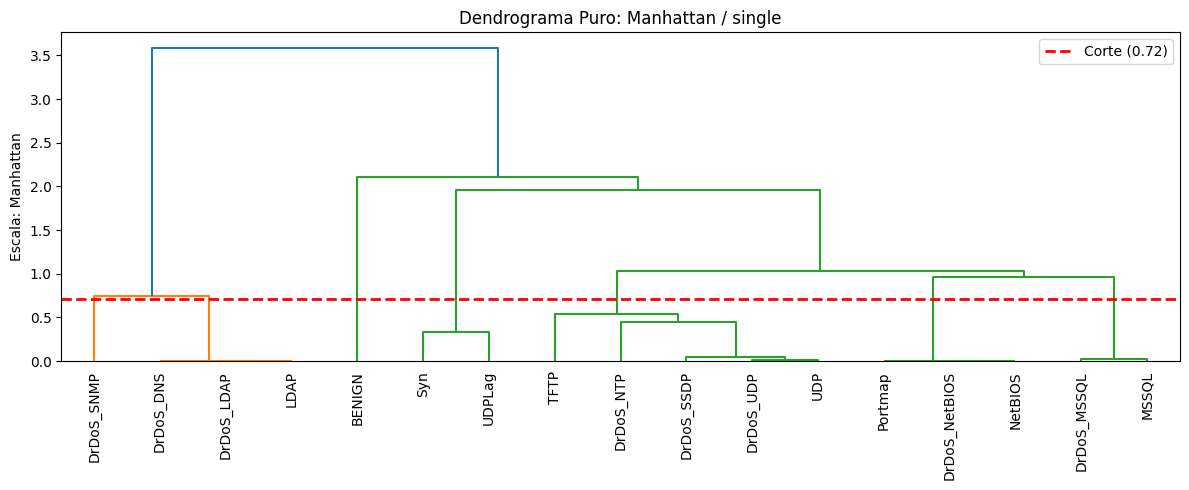

Corte utilizado: 1.43
Métrica: MANHATTAN
Ligação: COMPLETE


,Grupo ID,Qtd,Ataques,Manhattan,Assinatura
0,1,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.3759,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
1,2,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.3787,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,5,"DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap",0.5848,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
3,4,2,"Syn, UDPLag",0.3333,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
4,5,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


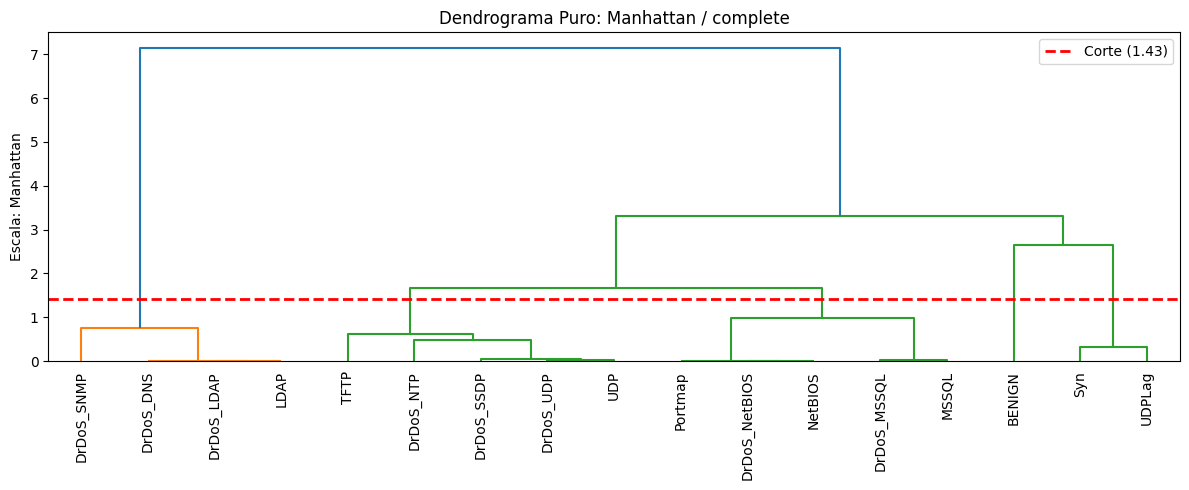

Corte utilizado: 1.02
Métrica: MANHATTAN
Ligação: AVERAGE


,Grupo ID,Qtd,Ataques,Manhattan,Assinatura
0,1,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.3759,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
1,2,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.3787,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,5,"DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap",0.5848,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
3,4,2,"Syn, UDPLag",0.3333,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
4,5,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


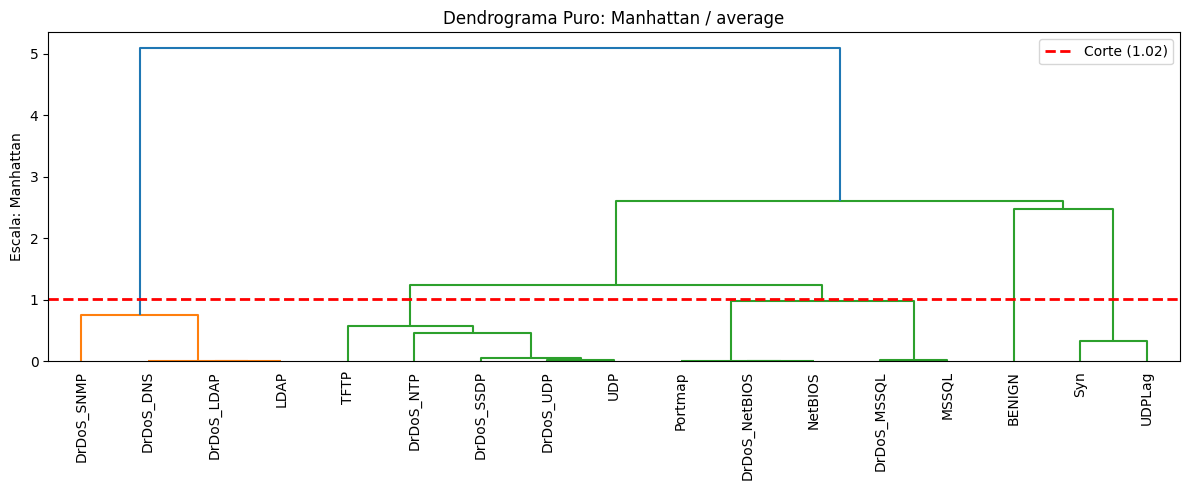

Corte utilizado: 0.25
Métrica: EUCLIDIANA
Ligação: SINGLE


,Grupo ID,Qtd,Ataques,Euclidiana,Assinatura
0,1,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
1,2,1,DrDoS_SNMP,Único,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,1,Syn,Único,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,4,1,UDPLag,Único,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
4,5,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.1379,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
5,6,3,"DrDoS_NetBIOS, NetBIOS, Portmap",0.0000,"Inbound, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Mean"
6,7,2,"DrDoS_MSSQL, MSSQL",0.0080,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
7,8,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


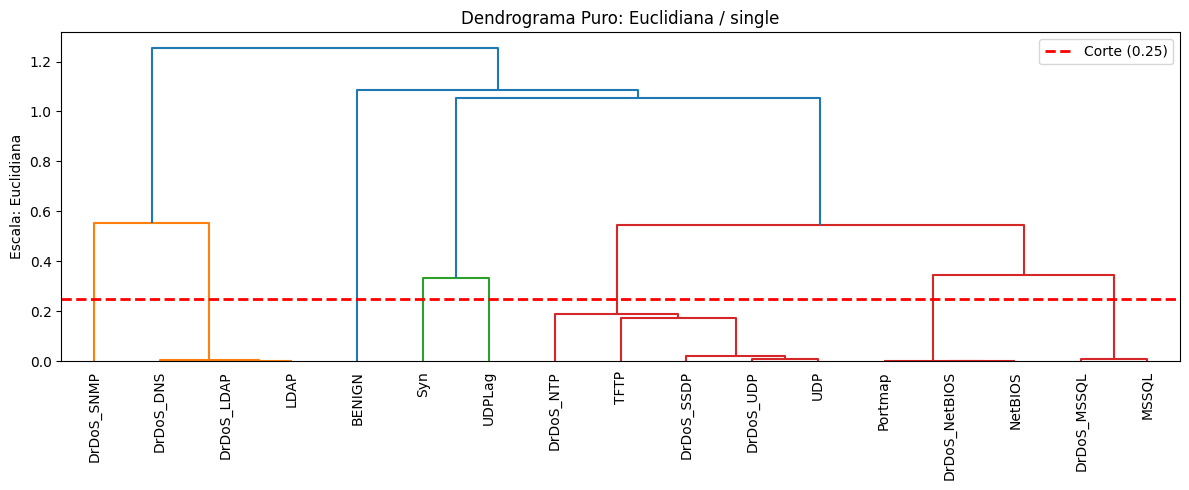

Corte utilizado: 0.47
Métrica: EUCLIDIANA
Ligação: COMPLETE


,Grupo ID,Qtd,Ataques,Euclidiana,Assinatura
0,1,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
1,2,1,DrDoS_SNMP,Único,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,2,"Syn, UDPLag",0.3333,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,4,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.1379,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
4,5,5,"DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap",0.2114,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
5,6,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


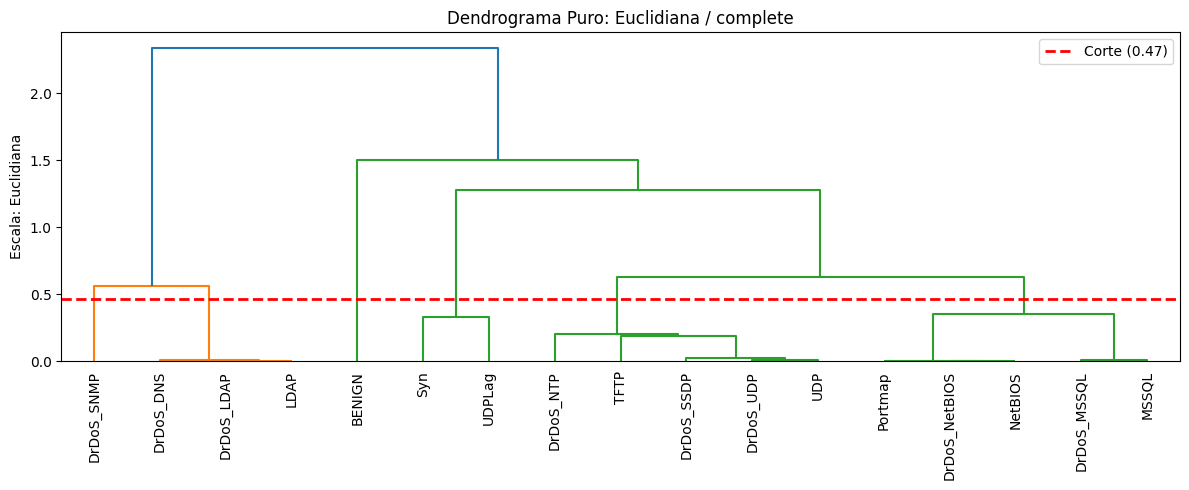

Corte utilizado: 0.35
Métrica: EUCLIDIANA
Ligação: AVERAGE


,Grupo ID,Qtd,Ataques,Euclidiana,Assinatura
0,1,3,"DrDoS_DNS, DrDoS_LDAP, LDAP",0.0036,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
1,2,1,DrDoS_SNMP,Único,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
2,3,2,"Syn, UDPLag",0.3333,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
3,4,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.1379,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
4,5,5,"DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap",0.2114,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
5,6,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


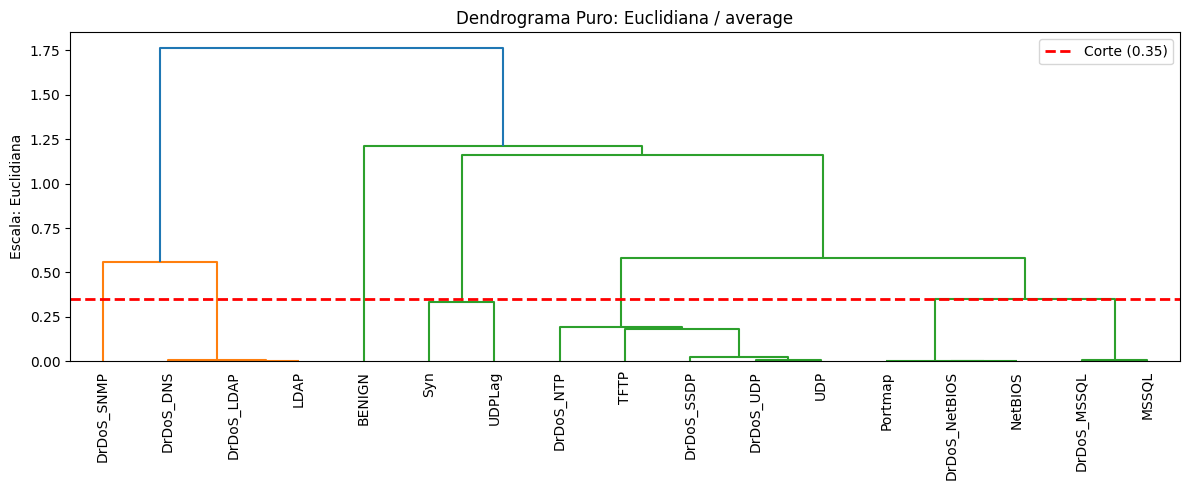

Corte utilizado: 0.07
Métrica: COSSENO
Ligação: SINGLE


,Grupo ID,Qtd,Ataques,Cosseno,Assinatura
0,1,2,"Syn, UDPLag",0.9754,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
1,2,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.9868,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
2,3,5,"DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP",0.9913,"Inbound, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min"
3,4,5,"DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap",0.9796,"Inbound, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean"
4,5,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


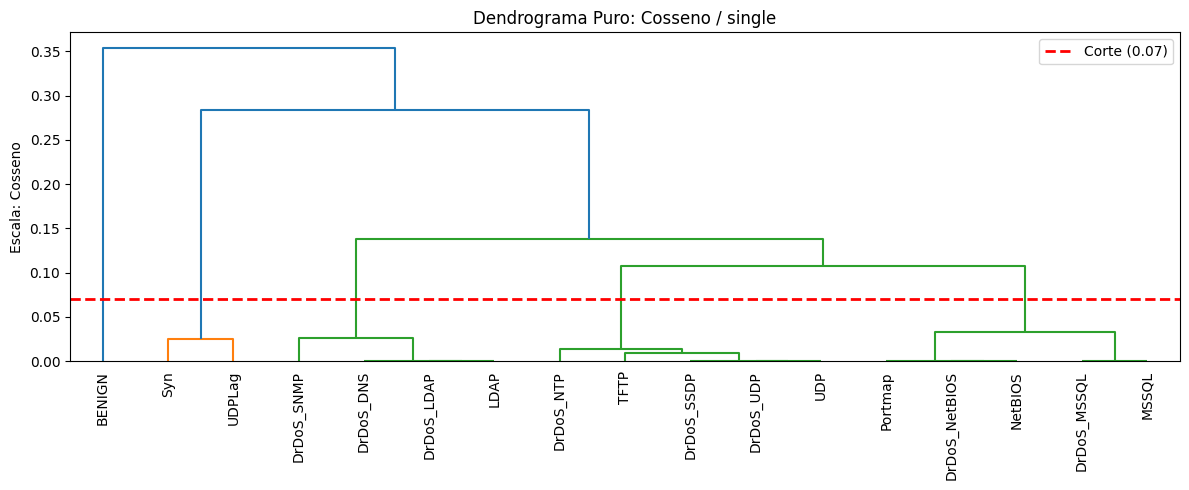

Corte utilizado: 0.20
Métrica: COSSENO
Ligação: COMPLETE


,Grupo ID,Qtd,Ataques,Cosseno,Assinatura
0,1,2,"Syn, UDPLag",0.9754,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
1,2,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.9868,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
2,3,10,"DrDoS_MSSQL, DrDoS_NTP, DrDoS_NetBIOS, DrDoS_SSDP, DrDoS_UDP, MSSQL, NetBIOS, Portmap, TFTP, UDP",0.9274,"Inbound, Flow Packets/s, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size"
3,4,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


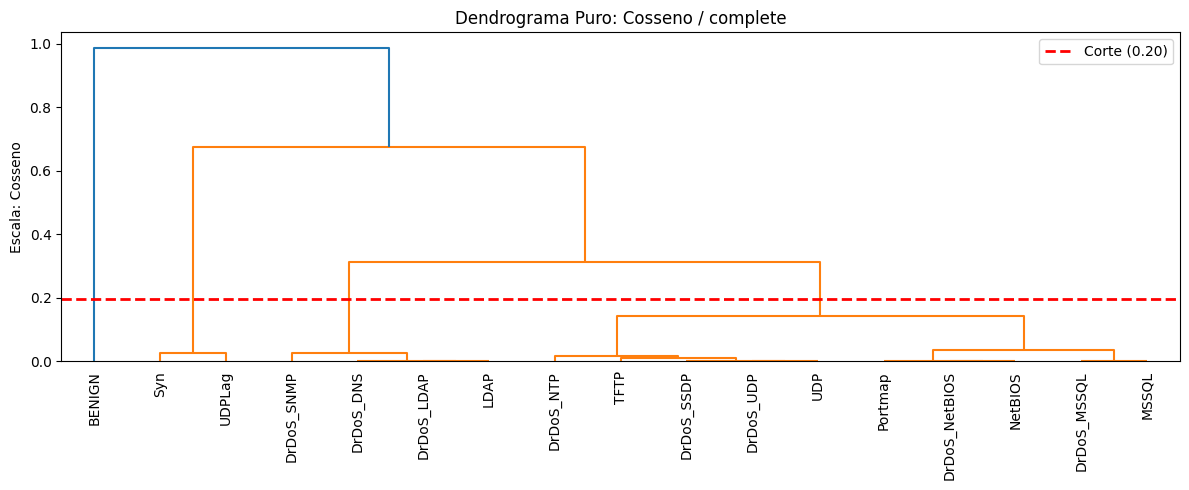

Corte utilizado: 0.13
Métrica: COSSENO
Ligação: AVERAGE


,Grupo ID,Qtd,Ataques,Cosseno,Assinatura
0,1,2,"Syn, UDPLag",0.9754,"Inbound, ACK Flag Count, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length"
1,2,4,"DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP",0.9868,"Inbound, Min Packet Length, Flow Bytes/s, Fwd Packet Length Mean, Avg Fwd Segment Size"
2,3,10,"DrDoS_MSSQL, DrDoS_NTP, DrDoS_NetBIOS, DrDoS_SSDP, DrDoS_UDP, MSSQL, NetBIOS, Portmap, TFTP, UDP",0.9274,"Inbound, Flow Packets/s, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size"
3,4,1,BENIGN,Único,"Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean, Fwd Packet Length Max"


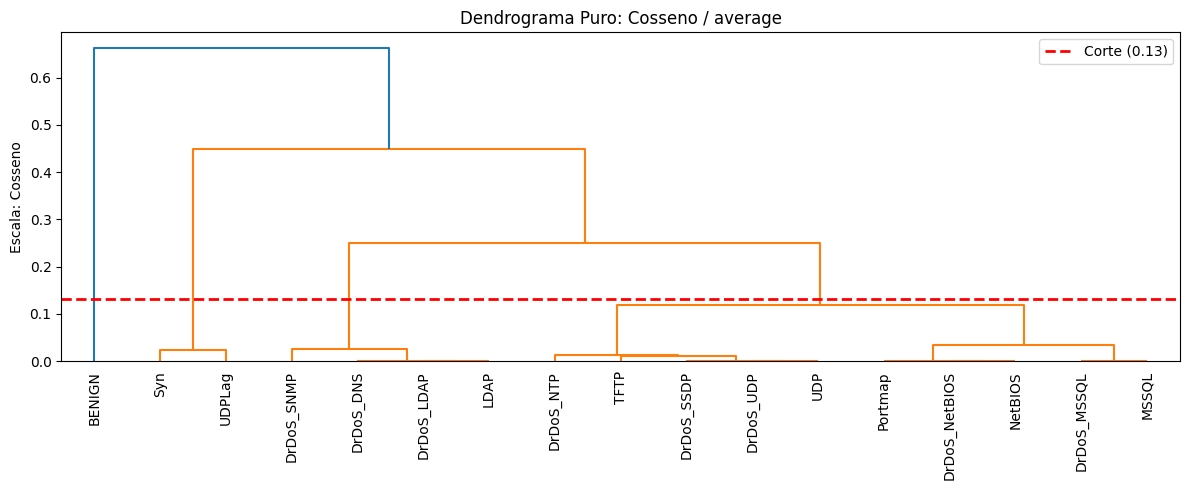

In [29]:
config_metricas = [
    ('Manhattan', 'cityblock'),
    ('Euclidiana', 'euclidean'),
    ('Cosseno', 'cosine')
]

config_linkage = ['single', 'complete', 'average']

for nome_metrica, str_metrica in config_metricas:
    # Calcula a matriz de distância condensada nativa
    dist_condensada_atual = pdist(df_final_sig, metric=str_metrica)
    # Converte para matriz quadrada para podermos calcular a média interna do grupo depois
    matriz_distancia_full = squareform(dist_condensada_atual)

    for metodo_link in config_linkage:
        # Hierarquia
        Z = linkage(dist_condensada_atual, method=metodo_link)

        # Definição do Corte 
        corte = 0.2 * max(Z[:, 2])
        lbl_corte = f"{corte:.2f}"
        tipo_medida = f"{nome_metrica}"

        # Clusterização
        final_labels = fcluster(Z, t=corte, criterion='distance')

        # Relatório 
        report = []
        for cid in sorted(set(final_labels)):
            membros = df_final_sig.index[final_labels == cid].tolist()
            indices_membros = np.where(final_labels == cid)[0]
            
            if len(membros) > 1:
                # Se tem grupo, calcula a média real
                sub_matriz = matriz_distancia_full[np.ix_(indices_membros, indices_membros)]
                valores_distancia = sub_matriz[np.triu_indices(len(membros), k=1)]
                media_distancia = valores_distancia.mean()
                
                # Formata o valor
                if str_metrica == 'cosine':
                    val_display = 1 - media_distancia # Converte dist volta para similaridade
                    val_str = f"{val_display:.4f}"
                else:
                    val_str = f"{media_distancia:.4f}"
            else:
                # Se for item único, não calculamos média (para não dar 1.0 ou 0.0 enganoso)
                val_str = "Único"

            # Assinatura
            avg_imp = df_final_sig.loc[membros].mean()
            top_feats = avg_imp.nlargest(5).index.tolist()
            
            report.append({
                'Grupo ID': cid,
                'Qtd': len(membros),
                'Ataques': ", ".join(membros),
                f'{tipo_medida}': val_str,
                'Assinatura': ", ".join(top_feats)
            })
        
        # Exibir Tabela
        print(f"Corte utilizado: {lbl_corte}")
        print(f"Métrica: {nome_metrica.upper()}")
        print(f"Ligação: {metodo_link.upper()}")
        display(pd.DataFrame(report))

        # Plotar Dendrograma
        plt.figure(figsize=(12, 5))
        dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
        plt.axhline(y=corte, c='r', ls='--', lw=2, label=f'Corte ({corte:.2f})')
        plt.title(f"Dendrograma Puro: {nome_metrica} / {metodo_link}")
        plt.ylabel(f"Escala: {tipo_medida}")
        plt.legend()
        plt.tight_layout()
        plt.show()

### DEVELOP CIC-IDS-2017

In [32]:
ARQUIVOS_ALVO = [
    'datasets\CIC-IDS-2017\Wednesday-workingHours.pcap_ISCX.csv',  
    'datasets\CIC-IDS-2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'     
]

df = carregar_e_unificar(ARQUIVOS_ALVO, 100000)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 918448 linhas.


Label
BENIGN              537749
DoS Hulk            231073
DDoS                128027
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

In [33]:
print("1. Preparação dos Dados")

TAMANHO_AMOSTRA = 40000

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df['Label'].unique())

df = df[df['Label'] != 'Heartbleed']

df_amostra = df.groupby('Label').apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=['Label'])
y = df_amostra['Label']

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = MinMaxScaler() 
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN              5714
DDoS                5714
DoS GoldenEye       5714
DoS Hulk            5714
DoS slowloris       5714
DoS Slowhttptest    5499
Name: count, dtype: int64

In [34]:
print("2. Seleção de Features e Extração de DNA Comportamental")

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)

# O X_trans agora já está entre 0 e 1 (correto)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] 
feature_names_final = X_numeric.columns[indices_top]

print(f"Features Selecionadas: {list(feature_names_final)}")

print(" > Calculando perfil típico de cada ataque...")

# Filtramos o dataset original (já normalizado Globalmente)
X_top_features = pd.DataFrame(X_trans, columns=X_numeric.columns).iloc[:, indices_top]
X_top_features['Label'] = y.values

# Calculamos a MEDIANA. 
df_final_sig = X_top_features.groupby('Label').median()

print(" > Matriz de Assinaturas (Comportamental) Gerada!")
display(df_final_sig)

2. Seleção de Features e Extração de DNA Comportamental
Features Selecionadas: ['Bwd Packet Length Max', 'Subflow Bwd Bytes', 'Fwd Packet Length Mean', 'Fwd IAT Mean', 'Flow Packets/s', 'Bwd Header Length', 'Packet Length Mean', 'Flow IAT Std', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Max Packet Length', 'Active Min', 'Flow IAT Mean', 'Total Length of Bwd Packets', 'Bwd Packet Length Std', 'Avg Bwd Segment Size', 'Fwd Packet Length Max', 'Init_Win_bytes_forward', 'min_seg_size_forward']
 > Calculando perfil típico de cada ataque...
 > Matriz de Assinaturas (Comportamental) Gerada!


,Bwd Packet Length Max,Subflow Bwd Bytes,Fwd Packet Length Mean,Fwd IAT Mean,Flow Packets/s,Bwd Header Length,Packet Length Mean,Flow IAT Std,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd Packet Length Mean,Max Packet Length,Active Min,Flow IAT Mean,Total Length of Bwd Packets,Bwd Packet Length Std,Avg Bwd Segment Size,Fwd Packet Length Max,Init_Win_bytes_forward,min_seg_size_forward
Label,,,,,,,,,,,,,,,,,,,,
BENIGN,0.007050,0.000048,0.013291,3.333333e-08,2.849237e-05,0.000864,0.028250,0.000003,0.000256,0.000256,0.019601,0.008425,0.000000e+00,0.000134,0.000048,0.000000,0.019601,0.003536,0.001953,0.357143
DDoS,0.376547,0.004190,0.002412,4.224943e-03,8.251223e-07,0.001987,0.383700,0.011993,0.000095,0.000095,0.498925,0.376547,0.000000e+00,0.004225,0.004190,0.326066,0.498925,0.001725,0.003922,0.357143
DoS GoldenEye,0.373453,0.004201,0.018166,9.609017e-03,3.192987e-07,0.003628,0.257832,0.025130,0.001382,0.001382,0.375000,0.373453,5.467153e-05,0.009470,0.004201,0.262443,0.375000,0.031997,0.445572,0.571429
DoS Hulk,0.373453,0.004188,0.015812,1.025000e-01,4.875918e-08,0.004319,0.366652,0.290598,0.001214,0.001214,0.427208,0.373453,4.379562e-07,0.055009,0.004188,0.262160,0.427208,0.027943,0.003845,0.571429
DoS Slowhttptest,0.000000,0.000000,0.000000,8.750000e-02,3.139850e-08,0.000000,0.000000,0.145299,0.000000,0.000000,0.000000,0.000000,5.112655e-01,0.087500,0.000000,0.000000,0.000000,0.000000,0.445572,0.714286
DoS slowloris,0.000000,0.000000,0.002757,5.869524e-02,5.437660e-08,0.001382,0.002332,0.152625,0.000059,0.000059,0.000000,0.000688,3.211679e-06,0.048910,0.000000,0.000000,0.000000,0.000690,0.445572,0.571429


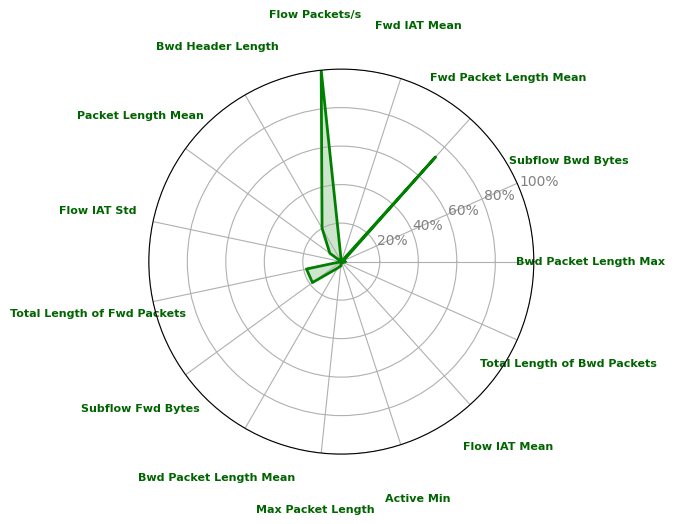

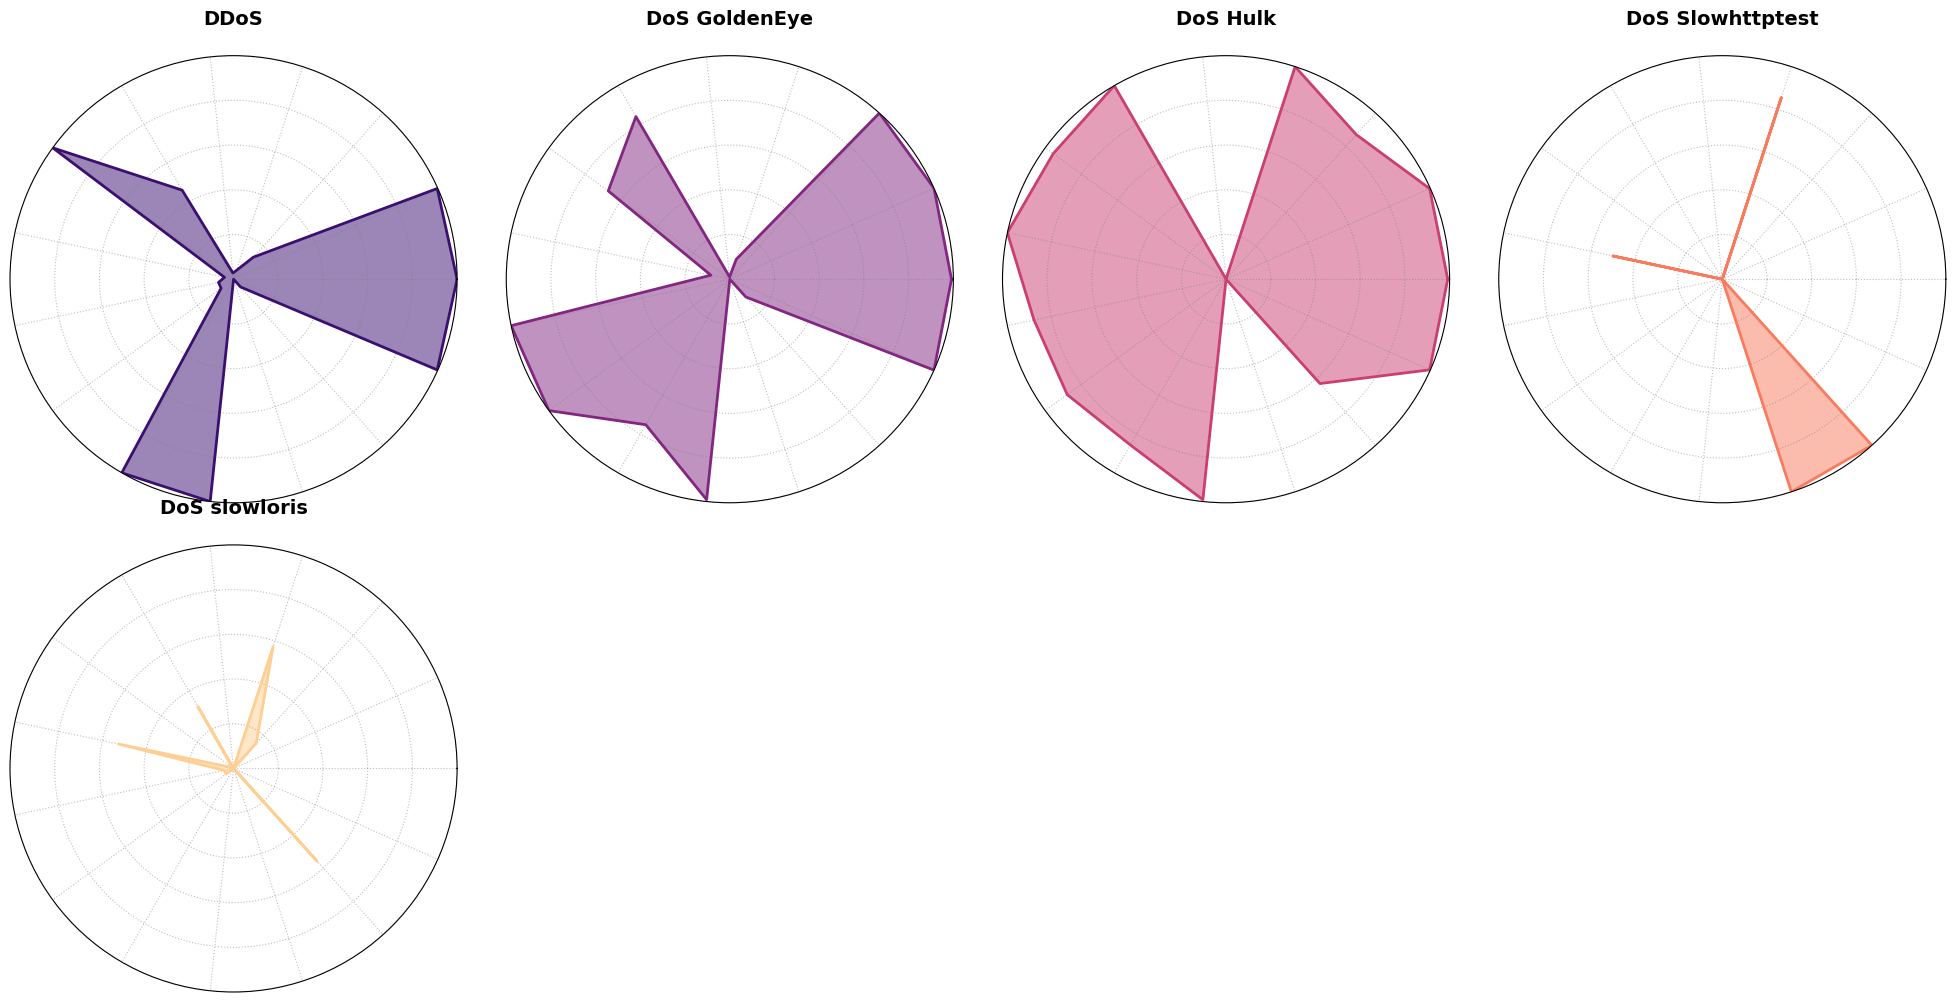

In [35]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares_separados_referencia(df_radar_ready, features_para_plotar)

Corte utilizado: 0.46
Métrica: MANHATTAN
Ligação: SINGLE


,Grupo ID,Qtd,Ataques,Manhattan,Assinatura
0,1,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"
1,2,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
2,3,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
3,4,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
4,5,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
5,6,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"


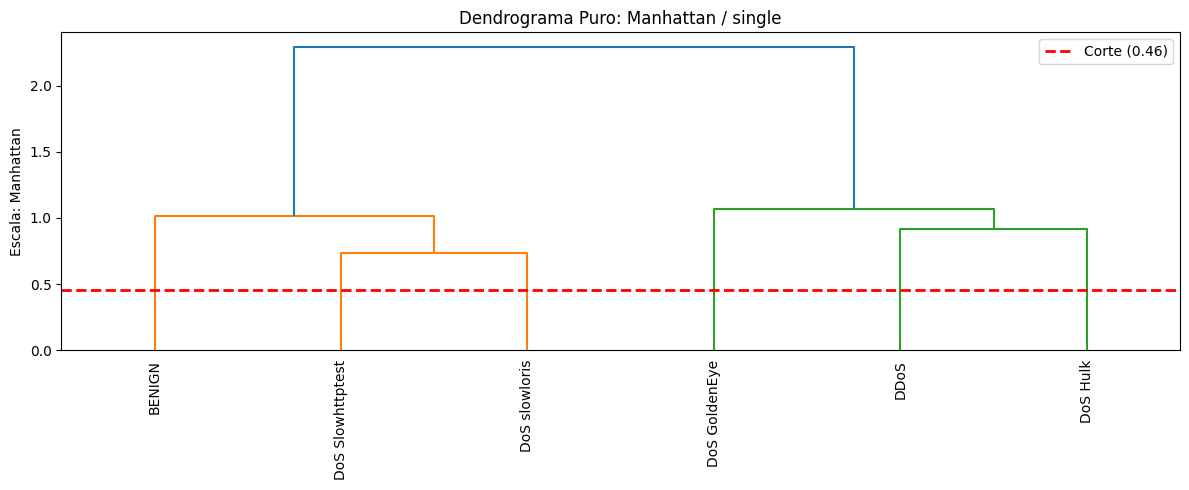

Corte utilizado: 0.82
Métrica: MANHATTAN
Ligação: COMPLETE


,Grupo ID,Qtd,Ataques,Manhattan,Assinatura
0,1,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
1,2,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
2,3,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
3,4,2,"DoS Slowhttptest, DoS slowloris",0.7368,"min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean"
4,5,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


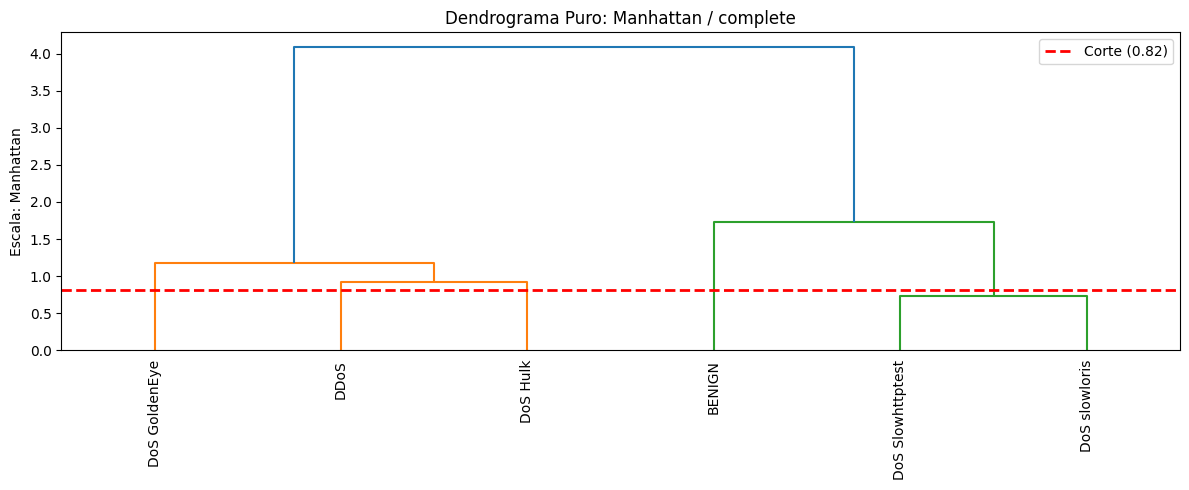

Corte utilizado: 0.60
Métrica: MANHATTAN
Ligação: AVERAGE


,Grupo ID,Qtd,Ataques,Manhattan,Assinatura
0,1,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
1,2,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
2,3,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
3,4,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"
4,5,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
5,6,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


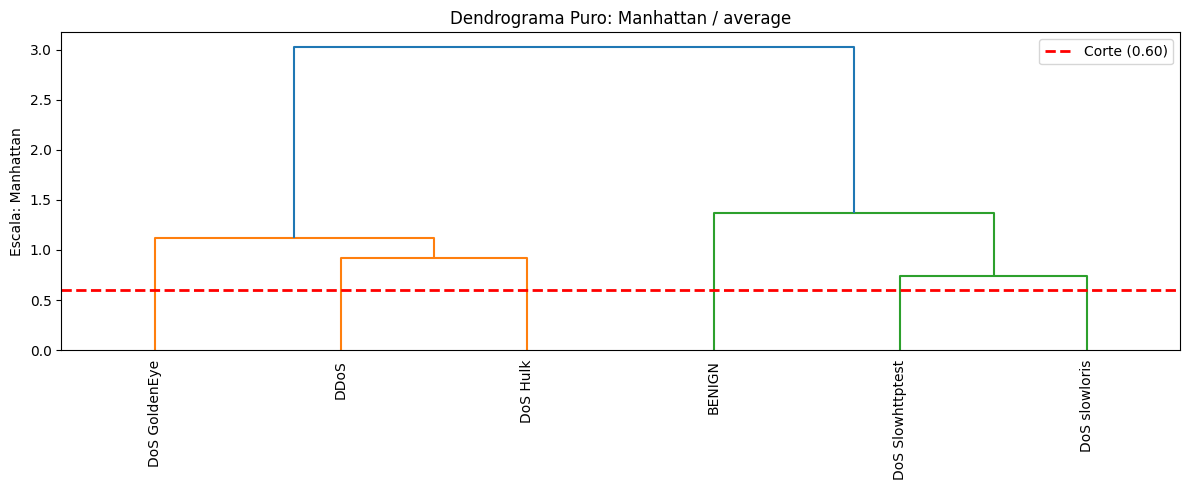

Corte utilizado: 0.17
Métrica: EUCLIDIANA
Ligação: SINGLE


,Grupo ID,Qtd,Ataques,Euclidiana,Assinatura
0,1,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
1,2,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
2,3,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"
3,4,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
4,5,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
5,6,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"


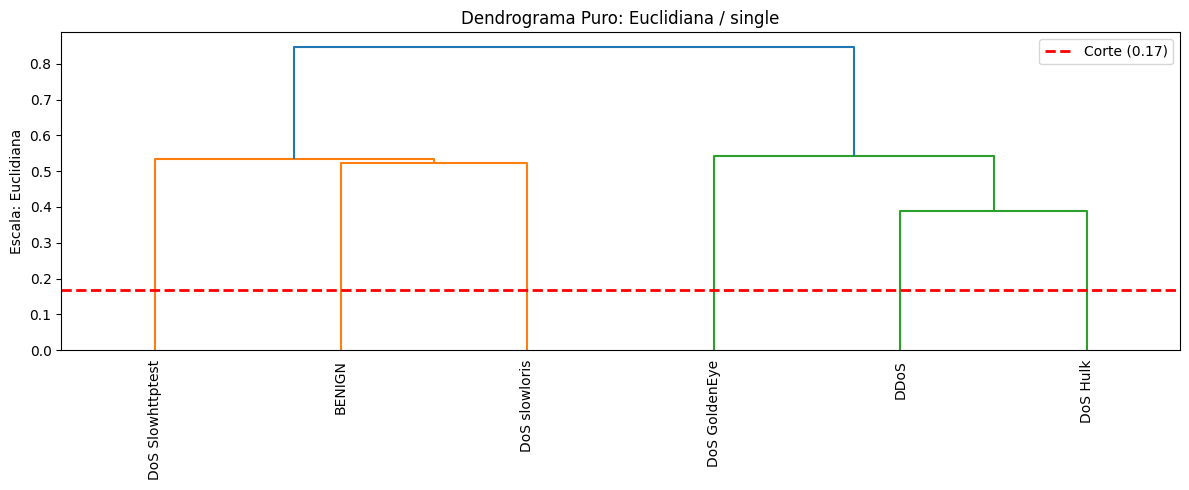

Corte utilizado: 0.26
Métrica: EUCLIDIANA
Ligação: COMPLETE


,Grupo ID,Qtd,Ataques,Euclidiana,Assinatura
0,1,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
1,2,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
2,3,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
3,4,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
4,5,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
5,6,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"


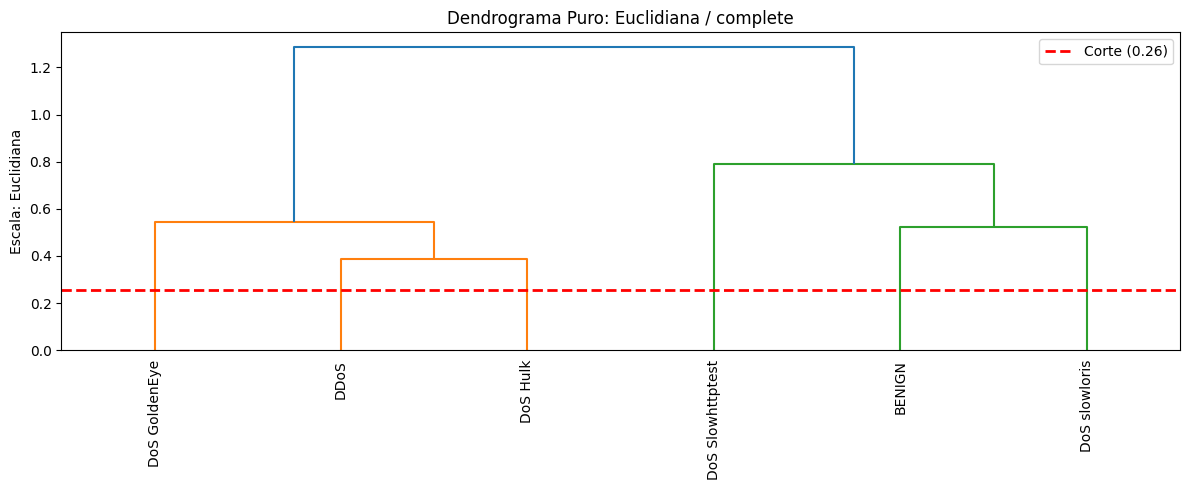

Corte utilizado: 0.21
Métrica: EUCLIDIANA
Ligação: AVERAGE


,Grupo ID,Qtd,Ataques,Euclidiana,Assinatura
0,1,1,DDoS,Único,"Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length"
1,2,1,DoS Hulk,Único,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
2,3,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
3,4,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"
4,5,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
5,6,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"


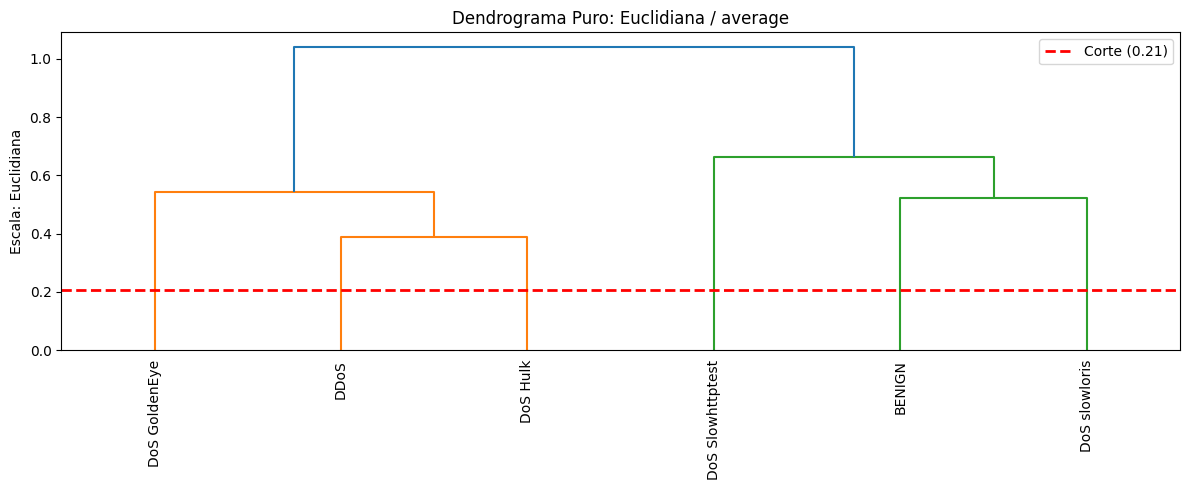

Corte utilizado: 0.07
Métrica: COSSENO
Ligação: SINGLE


,Grupo ID,Qtd,Ataques,Cosseno,Assinatura
0,1,2,"DDoS, DoS Hulk",0.9388,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max"
1,2,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
2,3,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"
3,4,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
4,5,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


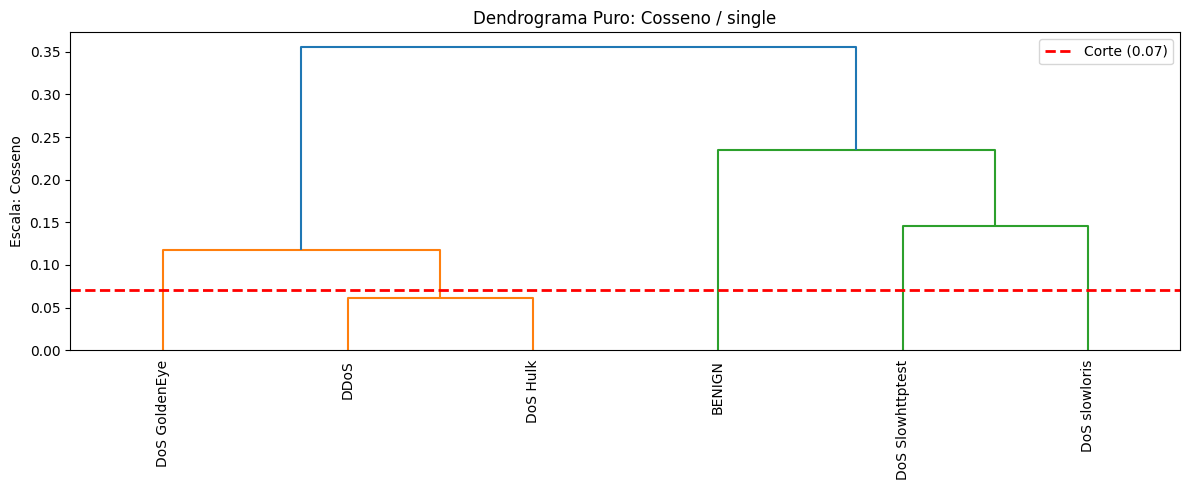

Corte utilizado: 0.15
Métrica: COSSENO
Ligação: COMPLETE


,Grupo ID,Qtd,Ataques,Cosseno,Assinatura
0,1,3,"DDoS, DoS GoldenEye, DoS Hulk",0.8996,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length"
1,2,2,"DoS Slowhttptest, DoS slowloris",0.8546,"min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean"
2,3,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


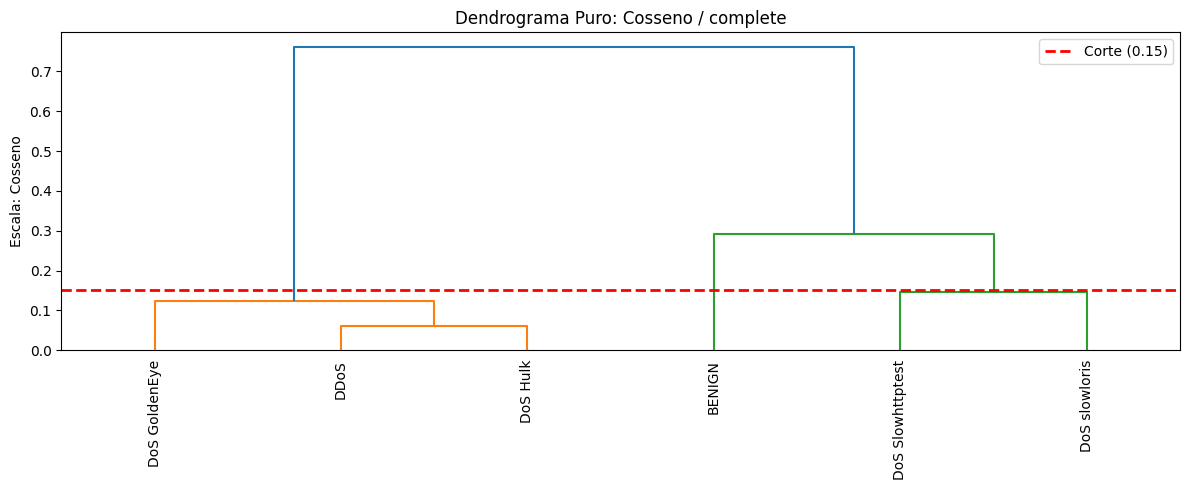

Corte utilizado: 0.11
Métrica: COSSENO
Ligação: AVERAGE


,Grupo ID,Qtd,Ataques,Cosseno,Assinatura
0,1,2,"DDoS, DoS Hulk",0.9388,"min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max"
1,2,1,DoS GoldenEye,Único,"min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max"
2,3,1,DoS Slowhttptest,Único,"min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean"
3,4,1,DoS slowloris,Único,"min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean"
4,5,1,BENIGN,Único,"min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean"


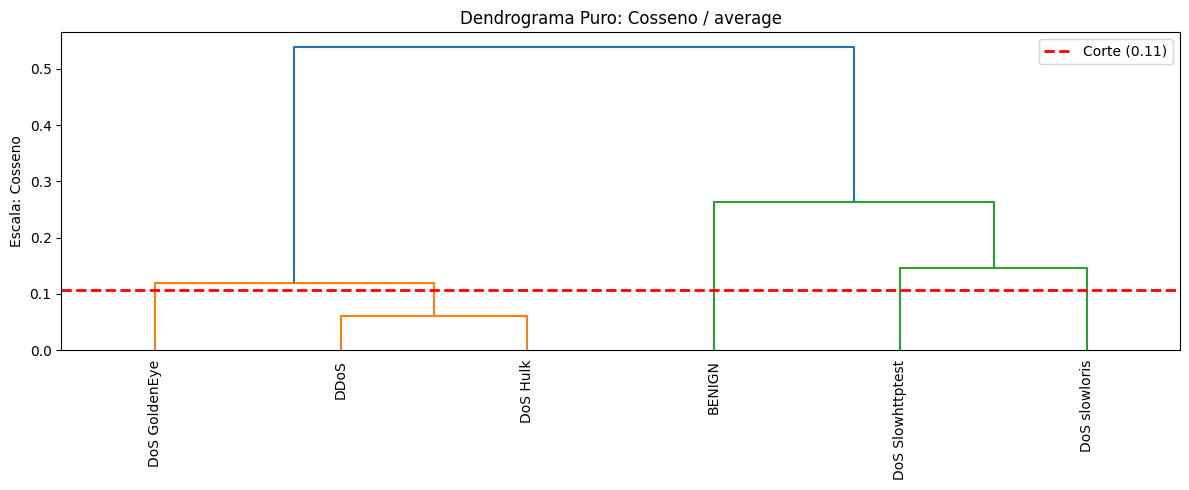

In [36]:
config_metricas = [
    ('Manhattan', 'cityblock'),
    ('Euclidiana', 'euclidean'),
    ('Cosseno', 'cosine')
]

config_linkage = ['single', 'complete', 'average']

for nome_metrica, str_metrica in config_metricas:
    # Calcula a matriz de distância condensada nativa
    dist_condensada_atual = pdist(df_final_sig, metric=str_metrica)
    # Converte para matriz quadrada para podermos calcular a média interna do grupo depois
    matriz_distancia_full = squareform(dist_condensada_atual)

    for metodo_link in config_linkage:
        # Hierarquia
        Z = linkage(dist_condensada_atual, method=metodo_link)

        # Definição do Corte 
        corte = 0.2 * max(Z[:, 2])
        lbl_corte = f"{corte:.2f}"
        tipo_medida = f"{nome_metrica}"

        # Clusterização
        final_labels = fcluster(Z, t=corte, criterion='distance')

        # Relatório 
        report = []
        for cid in sorted(set(final_labels)):
            membros = df_final_sig.index[final_labels == cid].tolist()
            indices_membros = np.where(final_labels == cid)[0]
            
            if len(membros) > 1:
                # Se tem grupo, calcula a média real
                sub_matriz = matriz_distancia_full[np.ix_(indices_membros, indices_membros)]
                valores_distancia = sub_matriz[np.triu_indices(len(membros), k=1)]
                media_distancia = valores_distancia.mean()
                
                # Formata o valor
                if str_metrica == 'cosine':
                    val_display = 1 - media_distancia # Converte dist volta para similaridade
                    val_str = f"{val_display:.4f}"
                else:
                    val_str = f"{media_distancia:.4f}"
            else:
                # Se for item único, não calculamos média (para não dar 1.0 ou 0.0 enganoso)
                val_str = "Único"

            # Assinatura
            avg_imp = df_final_sig.loc[membros].mean()
            top_feats = avg_imp.nlargest(5).index.tolist()
            
            report.append({
                'Grupo ID': cid,
                'Qtd': len(membros),
                'Ataques': ", ".join(membros),
                f'{tipo_medida}': val_str,
                'Assinatura': ", ".join(top_feats)
            })
        
        # Exibir Tabela
        print(f"Corte utilizado: {lbl_corte}")
        print(f"Métrica: {nome_metrica.upper()}")
        print(f"Ligação: {metodo_link.upper()}")
        display(pd.DataFrame(report))

        # Plotar Dendrograma
        plt.figure(figsize=(12, 5))
        dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
        plt.axhline(y=corte, c='r', ls='--', lw=2, label=f'Corte ({corte:.2f})')
        plt.title(f"Dendrograma Puro: {nome_metrica} / {metodo_link}")
        plt.ylabel(f"Escala: {tipo_medida}")
        plt.legend()
        plt.tight_layout()
        plt.show()

## Base de dados para verificar se os modelos identificam a semelhança entre os ataques durante o treinamento

In [17]:
import pandas as pd
import numpy as np
import os

def gerar_cenario_dinamico(df, sequencia_labels, pct_sujeira, tamanho_bloco_ataque, nome_cenario, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    df = df.drop(columns=['Origem_Arquivo', 'Unnamed: 0'], errors='ignore')
    
    df_benign_pool = df[df['Label'] == 'BENIGN'].sample(frac=1, random_state=42)
    total_benign_disponivel = len(df_benign_pool)
    
    qtd_ataques = len([x for x in sequencia_labels if x != 'BENIGN'])
    qtd_intervalos_benign = len([x for x in sequencia_labels if x == 'BENIGN'])
    
    qtd_ruido_por_ataque = int(tamanho_bloco_ataque * pct_sujeira)
    qtd_ataque_puro = int(tamanho_bloco_ataque * (1 - pct_sujeira))
    
    total_ruido_necessario = qtd_ruido_por_ataque * qtd_ataques
    
    if total_ruido_necessario > total_benign_disponivel:
        raise ValueError(f"Erro: Não há dados benignos suficientes para o ruído solicitado. Necessário: {total_ruido_necessario}, Disponível: {total_benign_disponivel}")
    
    df_noise_pool = df_benign_pool.iloc[:total_ruido_necessario]
    df_benign_intervals_pool = df_benign_pool.iloc[total_ruido_necessario:]
    
    tamanho_intervalo_benign = 0
    if qtd_intervalos_benign > 0:
        tamanho_intervalo_benign = int(len(df_benign_intervals_pool) / qtd_intervalos_benign)
    
    df_list = []
    metadata = []
    indice_global = 0
    
    idx_noise = 0
    idx_interval = 0
    
    for label in sequencia_labels:
        if label == 'BENIGN':
            start = idx_interval * tamanho_intervalo_benign
            end = start + tamanho_intervalo_benign
            
            chunk = df_benign_intervals_pool.iloc[start:end]
            df_list.append(chunk)
            
            metadata.append({
                'Evento': f"BENIGN_Intervalo_{idx_interval+1}",
                'Inicio': indice_global,
                'Fim': indice_global + len(chunk),
                'Tipo': 'Normal'
            })
            
            indice_global += len(chunk)
            idx_interval += 1
            
        else:
            start_noise = idx_noise * qtd_ruido_por_ataque
            end_noise = start_noise + qtd_ruido_por_ataque
            noise_chunk = df_noise_pool.iloc[start_noise:end_noise]
            
            try:
                attack_raw = df[df['Label'] == label].sample(n=qtd_ataque_puro, random_state=42 + idx_noise)
            except ValueError:
                print(f"Aviso: Dados insuficientes para o ataque {label}. Usando o que tem disponível.")
                attack_raw = df[df['Label'] == label]
            
            attack_block = pd.concat([attack_raw, noise_chunk]).sample(frac=1, random_state=42)
            df_list.append(attack_block)
            
            metadata.append({
                'Evento': f"ATAQUE_{label}",
                'Inicio': indice_global,
                'Fim': indice_global + len(attack_block),
                'Tipo': 'Ataque'
            })
            
            indice_global += len(attack_block)
            idx_noise += 1
            
    df_final = pd.concat(df_list, ignore_index=True)
    
    csv_name = f"stream_{nome_cenario}.csv"
    meta_name = f"metadata_{nome_cenario}.csv"
    
    df_final.to_csv(os.path.join(output_dir, csv_name), index=False)
    pd.DataFrame(metadata).to_csv(os.path.join(output_dir, meta_name), index=False)
    
    print(f"Cenário '{nome_cenario}' gerado com sucesso em: {output_dir}")
    print(f"Estrutura: {len(df_final)} linhas | {pct_sujeira*100}% de sujeira nos ataques.")
    
    return df_final, metadata

In [20]:
DIRETORIO_BASE = r"datasets\CICDDoS2019\Experimentos"
TAMANHO_BLOCO = 30000  
SUJEIRA = 0.40         

sequencia_c1 = [
    'BENIGN', 
    'DrDoS_LDAP', 
    'BENIGN', 
    'DrDoS_NetBIOS', 
    'BENIGN', 
    'Syn', 
    'BENIGN'
]

df_c1, meta_c1 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c1,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Imunidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_1")
)

sequencia_c2 = [
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN', 
    'DrDoS_MSSQL', 
    'BENIGN', 
    'DrDoS_UDP', 
    'BENIGN'
]

df_c2, meta_c2 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c2,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Memoria",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_2")
)

sequencia_c3 = [
    'BENIGN', 
    'UDP', 
    'BENIGN', 
    'DrDoS_NTP', 
    'BENIGN', 
    'DrDoS_DNS', 
    'BENIGN'
]

df_c3, meta_c3 = gerar_cenario_dinamico(
    df=df_analise,
    sequencia_labels=sequencia_c3,
    pct_sujeira=SUJEIRA,
    tamanho_bloco_ataque=TAMANHO_BLOCO,
    nome_cenario="Complexidade",
    output_dir=os.path.join(DIRETORIO_BASE, "Exp_3")
)

Cenário 'Imunidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_1
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'Memoria' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_2
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
Cenário 'Complexidade' gerado com sucesso em: datasets\CICDDoS2019\Experimentos\Exp_3
Estrutura: 167828 linhas | 40.0% de sujeira nos ataques.
